In [1]:
from card_engine import Card_Game, Card_Env, random_agent

In [2]:
import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

from itertools import count

from tqdm import tqdm

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Replay Memory

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Q network

In [4]:
class DQN(nn.Module):

    # n_input: the current state
    #  (1x52)    +  (56x52)       +       (1x52): the current state
    #    ^hand       ^who plays each card  ^cards not seen yet
    #                       + cards played
    # n_output: probability of playing each card
    #   (1x52)
    def __init__(self, n_input, n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_output)

    def forward(self, x):
        if x.dtype == torch.float32:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        else:
            x=x.to(torch.float32)
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        return self.layer3(x)

# Training

### The network agent
Selects a move according to epsilon-greedy policy:
sometimes uses the model to select move, sometimes just select one randomally

In [5]:
'''
A single step optimization of the model using Deep Q-Learning
1) samples a batch from memory, concatenates all the tensors into a single one
2) computes Q(s_t, a_t) and V(s_{t+1}) = max_a Q(s_{t+1}, a), where s_t --(a_t)--> s_{t+1}
3) computes the loss
4) updates the target network (which is computing V(s_{t+1})) at every step with soft update
'''
def optimize_model():
    transitions = []
    for turn, mem in memory.items():
        if len(mem) >= BATCH_SIZE:
            transitions += mem.sample(BATCH_SIZE)
    if transitions == []:
        return

    # transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # mask the non final states and find the corresponding next states
    # We need an illegal move to be a non-final state
    # Right now, we are throwing out all the final states which include the case when
    # the agent ends the game prematurely after playing an illegal move


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # print('non_final_mask is', non_final_mask)
    non_final_next_states = [s for s in batch.next_state if s is not None]

    non_final_next_states = torch.cat(non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print('reward_batch is', reward_batch)


    # compute Q(s_t, a)
    # for each state in the batch, find the value of the corresponding action
    state_action_values = policy_net(state_batch.to(torch.float)).gather(1, action_batch)

    # compute V(s_{t+1}) = max_a Q(s_{t+1}, a) for the next_states using the target_net
    next_state_values = torch.zeros(len(transitions), device=device)
    # next_state_values = -10.0 * torch.ones(len(transitions), device=device)

    if non_final_next_states != []:

        with torch.no_grad():
            # print(non_final_mask.shape, target_net(non_final_next_states).max(1).values)
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values  # these will all be negative!

    # R + \gamma max_a Q(s', a)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # back propagate
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [8]:


# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

env = Card_Env()

CUDA is available. GPU can be used.
Device name: Tesla T4


In [9]:
def move_to_card(move):
    return ['2','3','4','5','6','7','8','9','10','J','Q','K','A'][move % 13], ['C', 'D', 'H', 'S'][int(move / 13)]

def simulate_game(policy, verbose=False, from_move=0):
    with torch.no_grad():
        moves_played = 0
        active_player = from_move % 4
        if verbose:
            print(f"Starting new game as player {active_player} from turn {from_move}.")
        test_game = Card_Game()
        for turn in range(52):
            if test_game.current_player != active_player or turn < from_move:
                move = test_game.sample_legal_move()
            else:
                # print(policy_net(test_game.get_network_input().to(device)))
                moves_played += 1
                move = policy_net(test_game.get_network_input().to(device)).argmax().item()
                if not(move in test_game.get_legal_moves()):
                    if verbose:
                        print(f"Tried to play illegal move {move_to_card(move)}")
                    return moves_played
            if verbose:
                print(f"Player {test_game.current_player} plays {move_to_card(move)}")
            test_game.play_card(move)
            if turn % 4 == 3 and verbose:
                print()
        return moves_played

In [10]:
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 5000

# I am making batch_size small here so that we can test if this goes through in shorter time
BATCH_SIZE = 100
MEMORY_SIZE = 10000

# Learning rate of the optimizer
LR = 1e-4

# soft update rate
TAU = 0.005

# future discount
# GAMMA = 1.0
GAMMA = 0


state = env.game.get_network_input()

n_input = len(state)
n_actions = 52

policy_net = DQN(n_input, n_actions).to(device)
# use a target network to prevent oscillation or divergence
target_net = DQN(n_input, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# target_net.load_state_dict(torch.load('ev_working_function.pth'))



optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = {turn: ReplayMemory(MEMORY_SIZE) for turn in range(13)}

steps_done = 0


In [12]:
'''
Given the game state, select an action by the epsilon-greedy policy
'''
def select_action(game):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # epsilon-greedy choice

    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the card with highest probability
            # predicted from the policy net
            # print(policy_net(game.get_network_input().to(torch.float32).to(device)))
            return policy_net(game.get_network_input().to(device)).max(0).indices.view(1,1)
    else:
        # random select a legal action
        return torch.tensor([[game.sample_legal_move()]], device=device, dtype=torch.long) #changed from long


episode_durations = []
episode_rewards = []

def plot_durations_rewards(show_result=False):
    fig, ax = plt.subplots(2, 1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

    title = 'Result' if show_result else 'Training...'
    ax[0].set_title(f'{title} Duations each Episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Duration')

    ax[1].set_title(f'{title} Rewards each Episode')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Reward')

    ax[0].plot(durations_t.numpy())
    ax[1].plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[0].plot(means.numpy())

    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[1].plot(means.numpy())

    fig.tight_layout()

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)

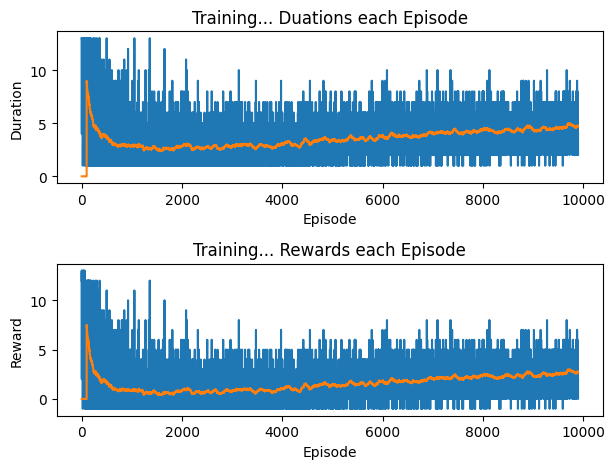

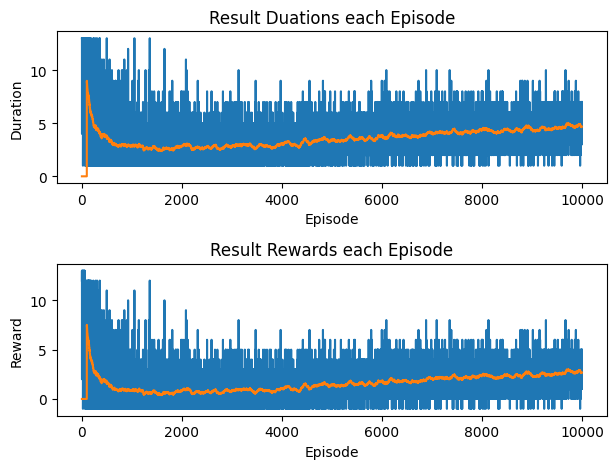

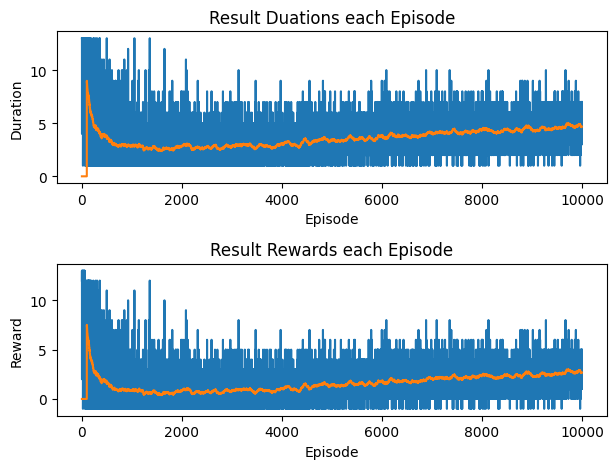

In [13]:
# fp =  DQN(n_input, 52).to(device)
# fp.load_state_dict(torch.load('latest_q_function.pth', map_location=torch.device('cpu')))

num_episodes = 10000
update_ind = 100

save_ind = 1000

rewards_list = []
benchmark = (-9.6, 1)

for i_episode in range(num_episodes):
    # if i_episode % save_ind == 0 and i_episode != 0:
    #     torch.save(policy_net.state_dict(), f'/content/drive/MyDrive/deep-learning/dqn/q_fn-{i_episode}.pth')

    if i_episode % update_ind == 0 and i_episode != 0:
        plot_durations_rewards()
        # print(f"Trained {i_episode} episodes")
        # avg_reward = sum(rewards_list) / len(rewards_list)
        # print(f'Average reward per episode: {avg_reward}.')
        # simul_results = []
        # simul_dist = [0 for i in range(13)]
        # for g in range(100):
        #     res = simulate_game(policy_net, verbose=False, from_move=random.randint(0,3))
        #     simul_results.append(res)
        #     simul_dist[res-1] += 1
        # print(f"Average simulated game duration: {sum(simul_results) / 100}")
        # print(f"Distribution of game lengths: {simul_dist}")
        # print(f"Memory bank: {[len(mem) for i, mem in memory.items()]}")
        # if benchmark[0] < avg_reward and benchmark[1] < sum(simul_results) / 100 and i_episode >= 10000:
        #     print("New benchmark set.")
        #     torch.save(policy_net.state_dict(), 'ev_q_function_output.pth')
        #     benchmark = (avg_reward, sum(simul_results) / 100)
        # rewards_list = []
        # print()


    env.reset()

    player_ind = random.randint(0, 3)
    while env.game.current_player != player_ind:
        move = env.game.sample_legal_move()
        env.game.play_card(move)

    current_reward = 0
    state = torch.tensor(env.game.get_network_input(), dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(env.game)
        # Select action based on policy network

        # with torch.no_grad():
        #     q_values = policy_net(state)
        #     action = q_values.max(1)[1].view(1, 1)

        # Perform action in the environment
        observation, reward, terminated = env.step(action.item(),fp=None)
        # rewards_list.append(reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        current_reward += reward

        # Compute next state
        if not terminated:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_state = None

        # Store transition in memory
        # int(env.game.turn_counter / 4)
        memory[t].push(state, action, next_state, reward)

        # Move to next state
        state = next_state

        # Perform optimization step
        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # print(f'Episode {i_episode} ended in {t} steps.')
            episode_durations.append(t+1)
            episode_rewards.append(current_reward)
            break

plot_durations_rewards(show_result=True)

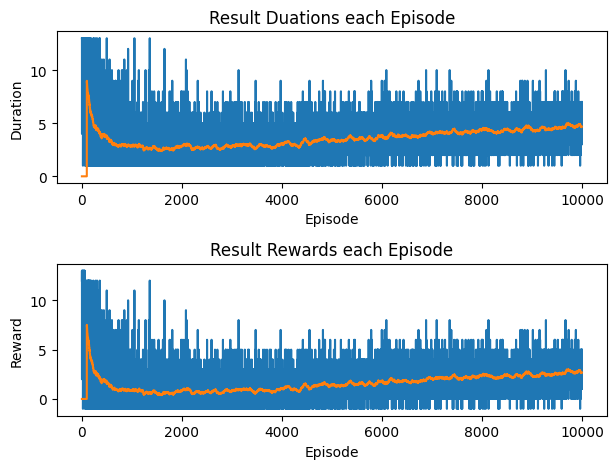

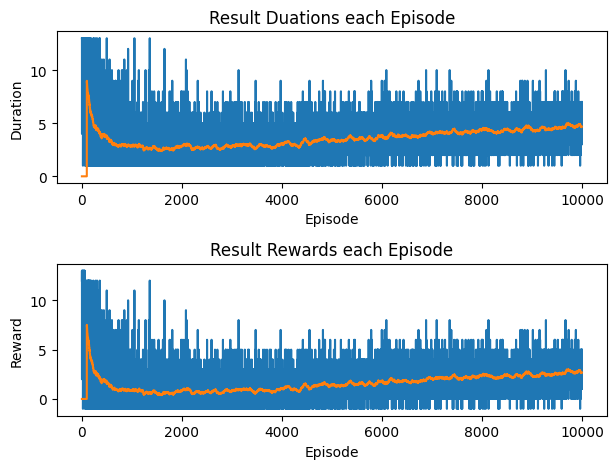

In [14]:
plot_durations_rewards(show_result=True)

In [ ]:
with torch.no_grad():
    print(policy_net(env.game.get_network_input().to(device)))
    print(target_net(env.game.get_network_input().to(device)))

tensor([-0.9546, -0.5844, -0.4574, -1.2084, -1.0869, -1.0918, -1.4656, -1.2313,
        -1.0549, -0.7106, -2.0822, -0.4221, -0.9491, -0.4860, -0.6145,  0.2269,
        -1.0714, -0.6811, -0.8308, -1.5493, -0.5715, -1.3406, -0.9525, -0.9850,
        -0.9726, -0.7995, -0.9468, -1.0974,  0.0172, -0.8877, -1.1226, -1.3161,
        -1.8605, -0.9081, -0.8001, -1.0292,  1.0503, -0.9325, -0.7132, -1.4409,
        -0.3147, -1.0980, -1.0895, -0.5870, -0.6940, -0.7582, -1.3339, -1.0823,
        -0.7390, -0.6515, -1.0162, -0.8305])
tensor([-0.4739, -0.3563, -0.2290, -0.5306, -0.5867, -0.5764, -0.8756, -0.6013,
        -0.5415, -0.3753, -0.5842, -0.1845, -0.3128, -0.2920, -0.3490, -0.1190,
        -0.5422, -0.3700, -0.5466, -0.5787, -0.3066, -0.7602, -0.4384, -0.4512,
        -0.4826, -0.4852, -0.5431, -0.5755, -0.1452, -0.5032, -0.5552, -0.5751,
        -0.5902, -0.4604, -0.2944, -0.5373,  0.1137, -0.4723, -0.4763, -0.6076,
        -0.2987, -0.4886, -0.5196, -0.3581, -0.3716, -0.4263, -0.5605, -0.5

In [15]:
with torch.no_grad():
    env.game.reset()
    net_input = env.game.get_network_input().to(device)
    hand = net_input[:52]
    cards = torch.arange(52).to(device)
    q_func = policy_net(net_input)
    print(f'{q_func.argmax()}')
    print(torch.stack((cards, hand, q_func)).transpose(0, 1))

35
tensor([[ 0.0000,  0.0000, -0.7533],
        [ 1.0000,  0.0000, -0.8193],
        [ 2.0000,  0.0000, -0.3490],
        [ 3.0000,  0.0000, -0.3325],
        [ 4.0000,  0.0000, -1.1007],
        [ 5.0000,  1.0000,  0.8281],
        [ 6.0000,  0.0000, -0.8454],
        [ 7.0000,  1.0000,  0.4737],
        [ 8.0000,  0.0000, -0.3227],
        [ 9.0000,  0.0000, -0.4856],
        [10.0000,  0.0000, -0.3975],
        [11.0000,  0.0000, -0.6302],
        [12.0000,  1.0000,  0.4254],
        [13.0000,  0.0000, -0.4012],
        [14.0000,  0.0000, -1.3515],
        [15.0000,  0.0000, -0.4080],
        [16.0000,  0.0000, -0.3180],
        [17.0000,  1.0000,  0.7590],
        [18.0000,  0.0000, -0.7087],
        [19.0000,  0.0000, -0.5810],
        [20.0000,  0.0000, -0.5203],
        [21.0000,  0.0000, -0.8274],
        [22.0000,  0.0000, -0.8167],
        [23.0000,  1.0000,  0.4693],
        [24.0000,  0.0000, -1.2007],
        [25.0000,  0.0000, -0.8866],
        [26.0000,  0.0000, -0.5802]

In [ ]:
torch.save(policy_net.state_dict(), 'ev_q_function_output.pth')

In [ ]:
# simulate_game(policy_net, verbose=True, from_move=random.randint(0,3))
simul_results = []
with torch.no_grad():
    simul_dist = [0 for i in range(13)]
    for g in range(1000):
        res = simulate_game(policy_net, verbose=False, from_move=random.randint(0,3))
        simul_results.append(res)
        simul_dist[res-1] += 1
    print(f"Average simulated game duration: {sum(simul_results) / 1000}")
    print(f"Distribution of game lengths: {simul_dist}")


Average simulated game duration: 1.111
Distribution of game lengths: [891, 107, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
simulate_game(policy_net, verbose=True, from_move=random.randint(0, 3))

Starting new game as player 2 from turn 2.
Player 0 plays ('10', 'D')
Player 1 plays ('8', 'D')
Player 2 plays ('J', 'D')
Player 3 plays ('3', 'D')

Tried to play illegal move ('J', 'D')


2